In [1]:
%matplotlib inline
from pprint import pprint
from metrics import wer, cew, ssr, average
import montecarlo
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import N_100_RebalanceHarvesting
from decimal import Decimal as D
from decimal import Decimal

import plot
from matplotlib import pyplot as plt

In [2]:
survival_function = mortality.make_mortality(mortality.HULSTROM)

In [14]:
def run_one(rate=D('.04'), basecase=montecarlo.conservative[40]):
    # The montecarlo used above has the stock/bond split baked in
    # So we pretend we have a 100% stock portfolio in order to handle
    # harvesting of cash
    p = Portfolio(1000000, 0)
    h = N_100_RebalanceHarvesting(p).harvest()
    h.send(None)
    w = withdrawal.ConstantWithdrawals(p, h, rate=rate).withdrawals()

    cashflows = []
    returns = []
    
    # the previous year's returns
    x = None

    # Couple is assumed to be age 65 (one male, one female)
    age = mortality.gen_age(survival_function)
    for i in range(age - 65 + 1):
        # Withdrawals happen at the start of the year
        # So we first withdraw cash.
        cashflows.append(w.send(x).withdraw_pct_orig)
        
        # Then the year happens and we store the returns
        x = basecase.random_year()
        returns.append(x.stocks)

    w = wer(cashflows, returns)
    #import pdb;pdb.set_trace()
    return w

In [15]:
wers = []
for i in range(100):
    wers.append(run_one(rate=D('.02'), basecase=montecarlo.conservative[0]))
my_wer = average(wers)
print(my_wer)

0.401802698313


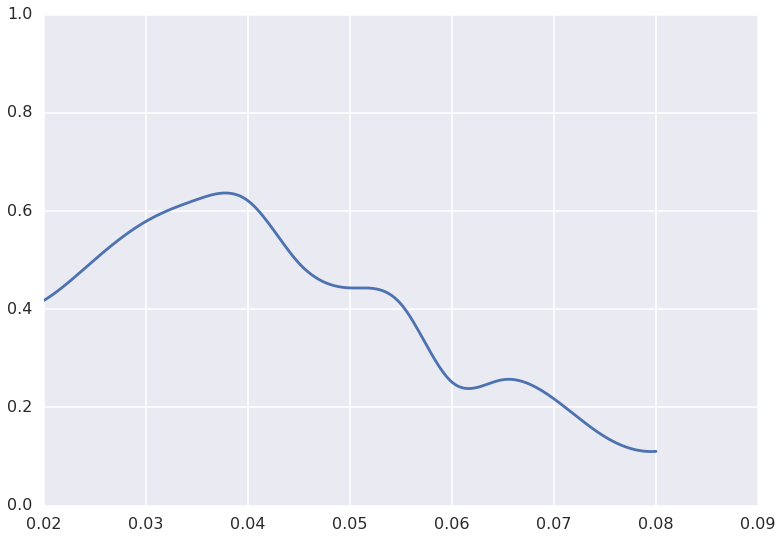

In [16]:
from scipy.interpolate import spline
import numpy as np

#canvas = plt.figure()

for equity in [0]:
    w = []
    r = []
    for rate in range(20, 81, 5):
        rate = Decimal(rate) / 1000
        case = montecarlo.conservative[equity]

        wers = []
        for i in range(200):
            wers.append(run_one(rate=rate, basecase=case))
        my_wer = average(wers)
        w.append(my_wer)
        r.append(rate)

    x_smooth = np.linspace(float(min(r)), float(max(r)), 200)
    y_smooth = spline(r, w, x_smooth)

    fig, ax1 = plt.subplots()
    ax1.set_ylim((0,1))
    plt.plot(x_smooth, y_smooth)